In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Naively Determining Undervalued Players in the NBA 

##### Tim Cruz 


## Introduction: 

This analysis will outline preliminary questions that may assist in recruiting undervalued players in the NBA. To do so, we will naively assume that a players points are the best metric to determine their value to a team. Points Per Minute (PPM) was also used as a proxy for their relative 'efficiency' on the court.


## Goals and Guiding Questions: 

This analysis is inspired by the Moneyball or Sabermetric approach to baseball player recruitment. That is, should a team face the task of building a team on a small budget, how could they go about doing so? While I will not be building a complete team, this analysis is a starting ground for people new to basketball to analyze basic statistics. This story will cover five guiding questions. 

The five guiding questions are: 
   1. What teams have small budgets compared to the rest of the NBA? 
   2. If we want to maximize offensive capability, what positions should be prioritized? 
   3. What is the best way to assign a player to a position? 
   4. Is there a way to determine a 'fair' salary for a player in the NBA? 
   5. What suggests that a player is undervalued? 
    




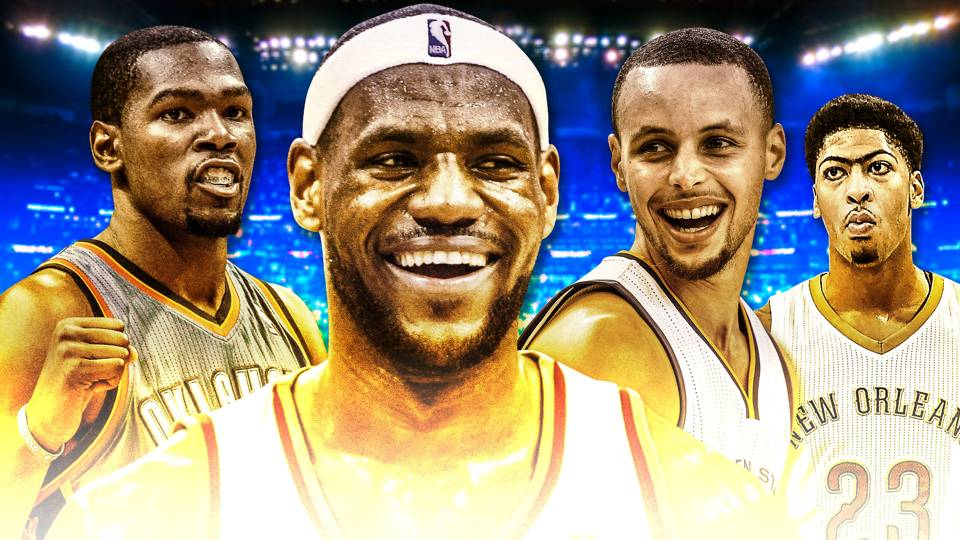

In [2]:
from IPython.display import Image
Image('nba-awards.png')

In [3]:
# Importing Libraries: 

import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
#import graphviz




In [4]:
import plotly 
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='tim.r.cruz', api_key='PvwzVGhIqLEMxlPbVSi3')


In [5]:
# Reading in Data: 
nba_stats = pd.read_csv("NBA 2015-16 stats.csv")
nba_hw = pd.read_csv('NBA stats.csv')
nba_salary = pd.read_csv('Salary.csv')
nba_salary.columns = ['Player', 'Salary']

In [6]:
nba_complete = pd.merge(nba_stats, nba_hw, left_on='Player', right_on='name' )
nba_complete = pd.merge(nba_complete, nba_salary, on='Player')
nba_complete.drop(['Unnamed: 0','position', 'name'], axis=1, inplace= True)

# Data Wrangling: 

Before tackling any questions, we first need to clean and wrangle the data. The analysis calls on three data sources, each containing important information. The first source contains information about each player's statistics for the 2015-2016 season. The second has their height and weight, and the final contains a players salary for the same season. The data sources were joined into a single data frame called 'nba_complete'. The data required a minimal cleaning and wrangling. Most of the work pertained to dropping irrelevant columns and ensuring labels were consistent.

Here is a snip of the final data: 



In [7]:
nba_complete['PPM'] = nba_complete['Points'] / nba_complete['MinutesPlayed']
nba_complete.iat[132, 3] = 'PF'
nba_complete.dropna(inplace = True)
nba_complete.head()

#nba_complete.to_csv('nba_complete.csv')

,Rk,Player,Id,Position,Age,Team,GamesPlayed,GamesStarted,MinutesPlayed,FieldGoals,...,Assists,Steals,Blocks,TurnoverPct,PersonalFouls,Points,height,weight,Salary,PPM
0,1,Quincy Acy,acyqu01,PF,25,SAC,59,29,876,119,...,27,29,24,27,103,307,79,240,981348,0.350457
1,2,Jordan Adams,adamsjo01,SG,21,MEM,2,0,15,2,...,3,3,0,2,2,7,77,209,1404600,0.466667
3,4,Arron Afflalo,afflaar01,SG,30,NYK,71,57,2371,354,...,144,25,10,82,142,909,77,215,8000000,0.383383
4,5,Alexis Ajinca,ajincal01,C,27,NOP,59,17,861,150,...,31,19,36,54,134,352,86,248,4539607,0.408827
6,7,LaMarcus Aldridge,aldrila01,PF,30,SAS,74,74,2261,536,...,110,38,81,99,151,1331,83,240,19689000,0.588678


# Exploratory Data Analysis: 

As someone with very little knowledge about the NBA, it was important for me to get a sense of the dataset. Since I knew the general flavor of the questions, I wanted to uncover any underlying relationships between the metrics in the data set. 


### EDA Plot 1: Correlation Matrix Heatmap: 

In order to get a sense of correlations between the metrics, I generated this heatmap. This shows the Pearson's correlation between all the numerical fields in the data set. The strength of the correlation is encoded to color, with dark red showing strong positive relationships, and dark blue showing  strong negative relationships. 

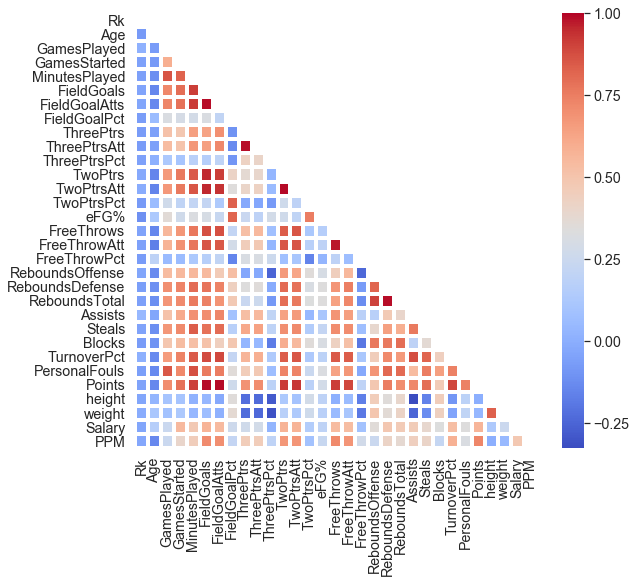

In [8]:
# Heatmap for nba_stats: 
corr = nba_complete.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (9,8))
sns.heatmap(corr, 
            xticklabels = corr.columns, 
            yticklabels = corr.columns,
            mask = mask, cmap= 'coolwarm', linewidth = 3)

### EDA Plot 2 - Player Salary: 

To get a sense of the salary distrbution, I used Tableau to generated an area chart. The chart descends from the highest paid players to the lowest. We can see the distribution decays rapidly, suggesting there are proportionaly less highly paid players. 


In [29]:
%%HTML 
<div class='tableauPlaceholder' id='viz1550181594249' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nb&#47;nba_complete&#47;PlayerSalary&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='nba_complete&#47;PlayerSalary' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nb&#47;nba_complete&#47;PlayerSalary&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550181594249');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### EDA Plot 3 - Height and Weight: 

To determine if there was a viable way to clasify a player's position, I plotted Height vs. Weight in Tableau. I colored each data point by position. From the plot, we see a natural cluster arise in different areas of height and weight. Additonaly, we see there is overlap between neighboring positions. 


In [36]:
%%HTML 
<div class='tableauPlaceholder' id='viz1550182018633' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nb&#47;nba_complete&#47;Heightvs_Weight&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='nba_complete&#47;Heightvs_Weight' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nb&#47;nba_complete&#47;Heightvs_Weight&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550182018633');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='800px';vizElement.style.height='627px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

# Analysis of Guiding Questions: 

Now that I have a sense of the data, we can begin answering our guiding questions. Here's how we'll approach it: 

1. What teams have small budgets compared to the rest of the NBA? 
    - A simple visualization should do. Perhaps a bar chart to compare the total dollars spend on players for each team?


2. If we want to maximize offensive capability, what positions should be prioritized? 
    - We need to define offensive capability. As someone new to basketball, I would think points is a good way to do that! 
    - Another simple visualization should do here. We just need to compare total points scored by each position. 


3. What is the best way to assign a player to a position? 
    - We know a relationship exists between height, weight, and position. 
    - We also know what position each player is currently assigned to. That sounds like a classification problem. 


4. Is there a way to determine a 'fair' salary for a player in the NBA? 
    - It would be helpful to determine if certain features of a player have a relationship to their salary. 
    - Maybe we can try a regression model to predict their salary? 
    - A regression model might be useful to help determine future salaries too! 


5. What suggests that a player is undervalued? 
    - We have to figure out some relationship between their salary and efficiency. 
    - I would also imagine that more experienced players cost more than rookies. 
    - My initial sense is that talented rookies would be a good starting point. 

### Question One: What teams have small budgets compared to the rest of the NBA? 

Here, I used Tableau to make a bar chart showing the sum of the salaries of all players on a team. This data suggests that Philadelphia only had a budget of around $24 Million. That doesn't seem right...perhpas the player salary data doesn't include players who moved teams during the season. That would explain the 'Null' column, which was originally 'Total'. Why don't we try using a different dataset? 

In [37]:
%%HTML 
<div class='tableauPlaceholder' id='viz1550182080224' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nb&#47;nba_complete&#47;TeamSalary&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='views&#47;nba_complete&#47;TeamSalary?:embed=y&amp;:display_count=y' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nb&#47;nba_complete&#47;TeamSalary&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550182080224');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Question One - Part 2: What teams have small budgets compared to the rest of the NBA? 

Again, I used Tableau to generate a bar chart, but with different data. [This](https://hoopshype.com/salaries/2015-2016/) is an accurate record of payroll by team. The visualization of this data makes much more sense. Here we see that Cleveland has the biggest budget, and Portland has the lowest. So now we know that teams like Portland, Orlando and Utah would be much more interested in this analysis. 

In [38]:
%%HTML 
<div class='tableauPlaceholder' id='viz1550182096374' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Team_11&#47;TeamPayroll&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Team_11&#47;TeamPayroll' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Team_11&#47;TeamPayroll&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550182096374');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Question 2: If we want to maximize offensive capability, what positions should be prioritized?

Another simple tableau visualization here. This is comparing the total points scored by players in each position. We can see that Shooting Guards are a team's primary point scorers, followed by Point Guards. So, if we naively assume that points are the best measure of a teams offense, we should focus on building a team around those positions. Additionaly, we know that Centres are not as important to offense, so perhaps a team could sacrifice investment into that position. 


In [39]:
%%HTML 
<div class='tableauPlaceholder' id='viz1550182129670' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nb&#47;nba_complete&#47;PointsPos&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='nba_complete&#47;PointsPos' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nb&#47;nba_complete&#47;PointsPos&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550182129670');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='800px';vizElement.style.height='627px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Question 3: What is the best way to assign a player to a position?

From the EDA, we know that Height and Weight give rise to clusters that align with position. We also know that each position is already labeled in the data set, so we can approach this question as a classification problem. 

To tackle the classification, I used a multinomial logistic regression to predct each player's position. To get more millage out of the data, I did a simple train/test split with the holdout method. I used 80% of the data to train the model, and the last 20% to test it. 

Overall, the performance wasn't too bad. The mean accuracy of the model was about 74%. By analyzing the confustion matrix, it seems that the misclassifcations came from positions that had overlap in the scatterplot from the EDA. 

This model is useful for a few reasons. It can help us confirm that a player is assigned to the correct position, determine an alternative position for the player, and can help us assign new players to positions. 

In [14]:
# First, we need a train/test split: 

hw = ['height', 'weight']
y = nba_complete['Position']

# create training and testing vars
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(nba_complete, y, test_size=0.2)
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)

In [15]:
# Training a multinomial regression model: 

nba_multinom = sk.linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg') 
nba_multinom.fit(X_train[hw], y_train)
print('Score:', nba_multinom.score(X_test[hw], y_test))

Score: 0.7402597402597403


C:\Users\timrc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



Text(0.5, 1.0, 'Confusion Matrix')

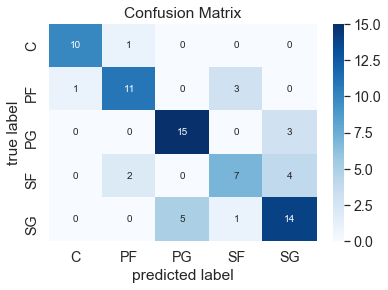

In [16]:
# Compute the confusion matrix
multinom_cfmat = skm.confusion_matrix(
    y_true=y_test,
    y_pred=nba_multinom.predict(X_test[hw]),)

# Visualize the confusion matrix
sns.heatmap(multinom_cfmat, 
            xticklabels=nba_multinom.classes_,
            yticklabels=nba_multinom.classes_,
            annot=True, 
            cmap = plt.cm.Blues)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')

### Question 4: Is there a way to determine a 'fair' salary for a player in the NBA?

Since salary is a continuous variable, I thought it would be appropriate to use a linear model. In order to select my explanatory variables, I relied on the heatmap from the EDA. I was looking for features that had a strong relationship to Salary. From the heatmap, it looks like GamesPlayed, Points, and TurnoverPct had the strongest relationship. Overall, I wanted to maintain a fairly simple model. 

Again, to make better use of the data, I used the holdout method to make a train/test split. 80% of the data trained the model, and 20% was used for testing. 

The model did not perform very well, with a mean accuracy score of around 38%, and an R-Squared of around .30. From the scatterplot, we can see that the model's predictions vs. the true values did not have much of a relationship. 

This question was a good lesson - sometimes the data doesn't have the answer! I spent a lot of time fiddling with the features, and trying different models. I exercised caution here - although I could eventually make a good model, I had to 'torture' the data quite a bit. I had a sense that this torturing was severely overfitting the model. Overall, it seems there are underlying factors (such as reputation) that affect a player's salary. In the future, it would be interesting to do a time-series analysis of a high profile player's salary.



In [17]:
# Train/Test Split for MLR: 

Xs = ['GamesPlayed','Points', 'TurnoverPct']
y1 = nba_complete['Salary']

# create training and testing vars
X_train1, X_test1, y_train1, y_test1 = sk.model_selection.train_test_split(nba_complete, y1, test_size=0.2)
#print(X_train1.shape, y_train1.shape)
#print(X_test1.shape, y_test1.shape)

In [18]:
# Training the MLR: 

nba_mlr = sk.linear_model.LinearRegression() 
nba_mlr.fit(X_train1[Xs], y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0, 0.5, 'Predictions')

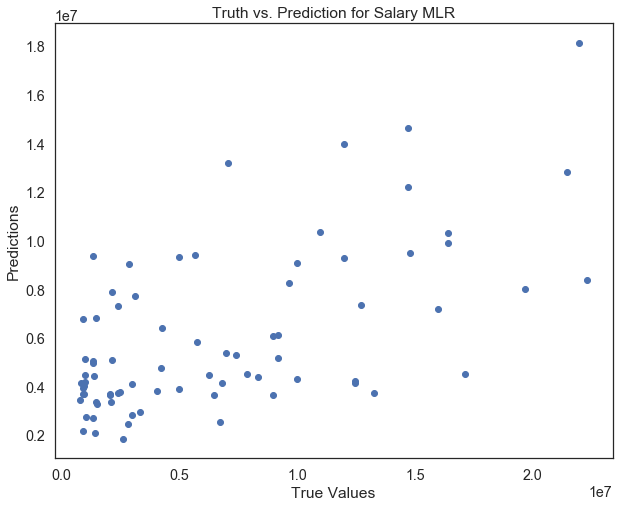

In [19]:
predictions1 = nba_mlr.predict(X_test1[Xs])

plt.figure(figsize=(10,8))
plt.scatter(y_test1, predictions1)
plt.title('Truth vs. Prediction for Salary MLR')
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [20]:
print('Score:', nba_mlr.score(X_train1[Xs], y_train1))
print('R-Squared:', sk.metrics.r2_score(y_test1, predictions1))

Score: 0.3715273804908683
R-Squared: 0.36427139718986434


### Question 5:  What suggests that a player is undervalued?

To tackle this question, I wanted to see if there was a relationship between a player's experience (measured by Minutes Played) and their salary. My naive intuition made me think that supestar players like Kobe Bryant and Lebron James would show up in the top left corner of a plot like this. Additionaly, I previously thought some linear relationship might show up, but the results of the regression analysis debunked that hunch. 

From the interactive plot below, we do see that result to some effect. Kobe Bryant and LeBron James are in the top right, along with other high profile players. We can also see there is no apparent linear relationship. That being said, it does make me wonder if there is a way to cluster the players into some rough price categories. 


In [21]:
# Create traces

trace0 = go.Scatter(
    x = nba_complete['MinutesPlayed'],
    y = nba_complete['Salary'],
    text = nba_complete['Player'],
    mode = 'markers',
    name = 'markers'
)

layout = go.Layout( 
    title = 'Minutes Played vs. Salary',
    hovermode = 'closest',
    xaxis= dict(
        title= 'Minutes Played',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Salary',
        ticklen= 5,
        gridwidth= 2,
    ),
    
)

data = [trace0]

fig= go.Figure(data=data, layout=layout)

py.iplot(fig)

### Question 5 - Part Two: What suggests that a player is undervalued? 

My idea of an undervalued player is someone with lots of game time, and a high PPM but a low salary. The rationale was that if a player is getting opportunities to play and performing well during those opportunities, they should be getting compensated more. 

To perform the clustering, I used an eblow plot to determine a base number of clusters. In this case, it when k = 3. Knowing K, I used k-means clustering with MinutesPlayed, Salary, and PPM as features. This gave 3 well defined clusters with an inherent stratification to it. The 3 clusters roughly represent 'Cheap', 'Moderate' and 'Expensive' players. While the split was satisfying, I felt that it did not sufficently seperate the superstar players like Kobe and Lebron. Because of this, I tried using k = 4. 

With k = 4, the split remained the same but a new cluster emerged at the top section of the plot. Using the final interactive scatterplot, I was able to determine that the players in that cluster were in fact the highly valuable superstars of the NBA. More importantly was the bottom tier of the plot. Of those in the bottom tier, I would naively interpret the players in the bottom right to be undervalued. These are players with lots of experience with low salaries - potentially really promising rookies or highly experienced players who underperform relative to the superstars. These would be players like Damian Lillard who seems to be [performing well](https://www.cbssports.com/fantasy/basketball/news/trail-blazers-damian-lillard-leads-trail-blazers-to-victory/) as of late. 

In [22]:
def elbow(df, pair): 
    # Elbow method to Determine K 
    X = df[pair].iloc[:,:2]  # Using the the dataset of Section 1
    K = range(1,11)  # Apply kmeans 1 to 10
    kmeans_models = [skc.KMeans(k).fit(X) for k in K]
    centroids = [m.cluster_centers_ for m in kmeans_models]
    D_k = [spd.cdist(X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]

    # plot elbow curve
    plt.figure(figsize = (7,7))
    plt.plot(K, avgWithinSS, 'b*-')
    plt.xlabel('Number of clusters');
    plt.ylabel('Average within-cluster sum of squares');
    plt.title('Elbow for K-Means clustering');
    plt.suptitle('{}'.format(pair))
    plt.show()

# A helper function to run and plot K-means:     
def kmeans(df, pair, k):
    # Fitting the K-Means model: 
    k_means_model = skc.KMeans(n_clusters=k)
    k_means_model.fit(df[pair])
    centroids = k_means_model.cluster_centers_
    centroids

    # Plot the clusters with their centroids.
    df['cluster_labels_kmeans'] = k_means_model.labels_
    f = sns.lmplot(x=pair[0], y=pair[1], data=df, hue = 'cluster_labels_kmeans', 
                   fit_reg=False, size=5, aspect=1.3)
    f.ax.scatter(centroids[:,0], centroids[:,1], marker='+', s=100,
                 linewidths=2, color='k');
    plt.title('{}'.format(pair), fontsize=15)

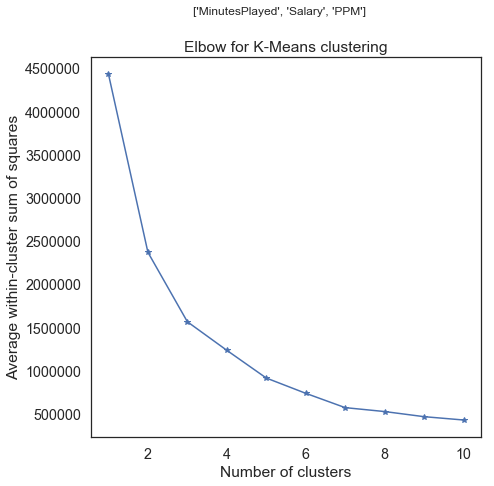

In [23]:
elbow(nba_complete, ['MinutesPlayed', 'Salary', 'PPM'])

C:\Users\timrc\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



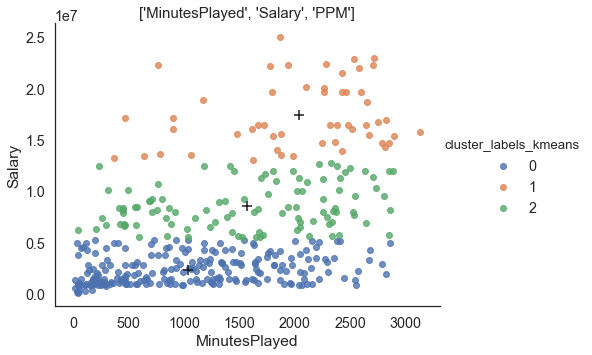

In [24]:
kmeans(nba_complete, ['MinutesPlayed', "Salary", 'PPM'], 3)

C:\Users\timrc\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



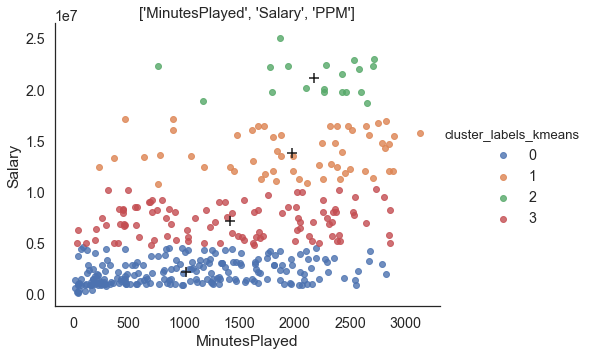

In [25]:
kmeans(nba_complete, ['MinutesPlayed', 'Salary', 'PPM'], 4)

In [26]:
def plotly_kmeans(df, pair, k):
    # Fitting the K-Means model: 
    k_means_model = skc.KMeans(n_clusters=k)
    k_means_model.fit(df[pair])
    centroids = k_means_model.cluster_centers_
    centroids

    # Plot the clusters with their centroids.
    #df['cluster_labels_kmeans'] = k_means_model.labels_
    #f = sns.lmplot(x=pair[0], y=pair[1], data=df, hue = 'cluster_labels_kmeans', 
    #               fit_reg=False, size=5, aspect=1.3)
    #f.ax.scatter(centroids[:,0], centroids[:,1], marker='+', s=100,
    #             linewidths=2, color='k');
    #plt.title('{}'.format(pair), fontsize=15)
    
    # Create traces

    trace0 = go.Scatter(
        x = nba_complete['MinutesPlayed'],
        y = nba_complete['Salary'],
        text = nba_complete['Player'],
        mode = 'markers',
        name = 'markers', 
        marker = dict(
        color = k_means_model.labels_
        )
    )

    layout = go.Layout( 
        title = 'Minutes Played vs. Salary',
        hovermode = 'closest',
        xaxis= dict(
            title= 'Minutes Played',
            ticklen= 5,
            zeroline= False,
            gridwidth= 2,
        ),
        yaxis=dict(
            title= 'Salary',
            ticklen= 5,
            gridwidth= 2,
        ),

    )

    data = [trace0]

    fig= go.Figure(data=data, layout=layout)

    py.iplot(fig)
    plt.show()

In [27]:
features = ['MinutesPlayed', 'Salary', 'PPM']

k_means_model = skc.KMeans(n_clusters=4)
k_means_model.fit(nba_complete[features])
centroids = k_means_model.cluster_centers_

# Create traces

trace0 = go.Scatter(
    x = nba_complete['MinutesPlayed'],
    y = nba_complete['Salary'],
    text = nba_complete['Player'],
    mode = 'markers',
    name = 'markers', 
    marker = dict(
        color = k_means_model.labels_,
        colorscale='Portland',
    )
)

layout = go.Layout( 
    title = 'Minutes Played vs. Salary',
    hovermode = 'closest',
    xaxis= dict(
        title= 'Minutes Played',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Salary',
        ticklen= 5,
        gridwidth= 2,
    ),
    
)

data = [trace0]

fig= go.Figure(data=data, layout=layout)

py.iplot(fig)

# Conclusion 

This was my first complete analysis of the NBA dataset. Like I said, I'm completely new to basketball to I understand the naive limitations of my analysis. Regardless, let's summarize our findings! 

1. What teams have small budgets compared to the rest of the NBA? 
    - In the words of Billy Beane, 'The problem we're trying to solve is that there are rich teams and there are poor teams.' 
    - We were able to confirm this. Teams like Cleveland are rich, and teams like Portland are poor. 
2. If we want to maximize offensive capability, what positions should be prioritized? 
    - If you want to score more points, recruit shooting guards and point guards. 
3. What is the best way to assign a player to a position? 
    - Height and weight is a tried and true method. 
    - We used logistic regression to solve this problem, but there are probably simpler methods out there. 
4. Is there a way to determine a 'fair' salary for a player in the NBA? 
    - I'm sure there is, but this data doesn't have the answer! 
    - A good lesson was learned here - you can torture data to tell you what you want to hear. As data scientists, we should know when to stop. 
5. What suggests that a player is undervalued? 
    - This was a nice clustering problem. 
    - From my analysis, I would naively assume that highly experinced players with small salaries are relatively undervalued. Superstars aren't the only players who can add value to a team. 

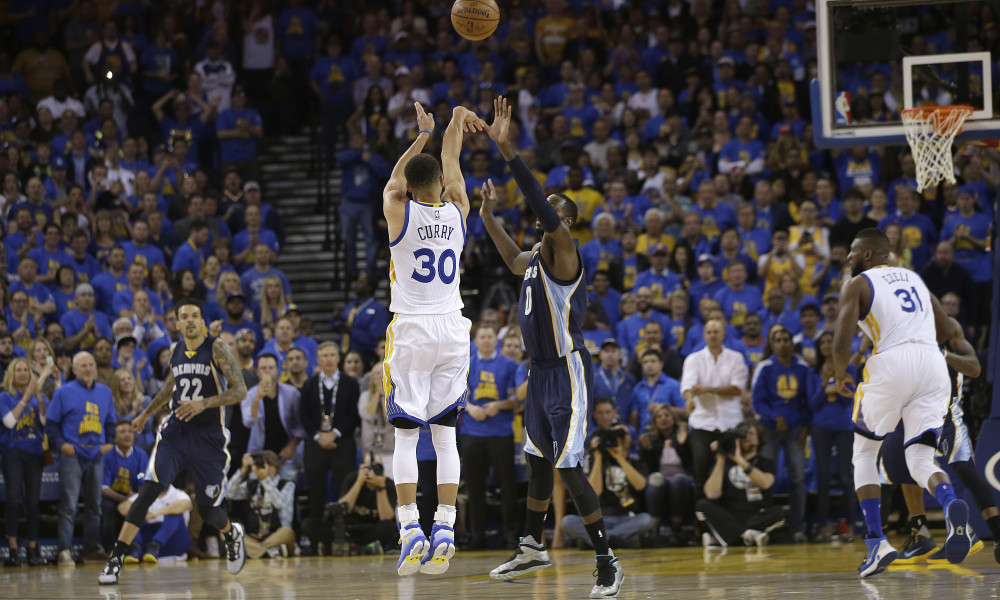

In [28]:
Image('Curry.png')